# Sample Code for Model Training (ward 10)

* This notebook contains sample use of code for the model phase. This step has not been evaluated after I have updated the interpolation phase. The idea should be the similar. 
* Intended to be called after PROCESS_interpolation.ipynb (interpolation phase)
* The model works on record-level
* Currently similarity label has not been included. More thinking is needed for this feature.

In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in data

In [14]:
#Change these values to rerun the notebook
preprocessed_census = pd.read_csv('../../data/census_interpolated_1850_mn_20201219.csv')
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv")

ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Keep only part for the model

* Remove records whose block numbers have previously been interpolated. This is to make sure that a mode is trained on correct data. However, this decision can be changed after some thinking/discussions 
* Remove records whose both distance seq and enum dist seq are not present (either empirically or interpolation). We can't do anything about them at this step.

In [15]:
preprocessed_census_model = preprocessed_census.loc[(preprocessed_census['filled_block_num'] == 0) &
                                              (~preprocessed_census['sequence_id'].isnull()) &
                                              (~preprocessed_census['enum_dist_id'].isnull())]


In [16]:
print('Total records: ', preprocessed_census.shape[0])
print('Records used in the model: ', preprocessed_census_model.shape[0])

Total records:  515630
Records used in the model:  9310


In [17]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby('CD_WARD_NUM')}

## Only work with ward 10

In [18]:
census_ward10 = preprocessed_census[preprocessed_census[ward_col] == 10]

In [19]:
census_ward10.head()

,CD_BLOCK_NUM,CD_H_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_FIRST_NAME,...,enum_dist_order,enum_dist,enum_sequence_len,filled_block_num,known_address,cluster,sequence_id,enum_dist_id,filled_sequence_id,filled_enum_dist_id
215441,NaN,NaN,NaN,NaN,16,MANHATTAN,1.0,1.0,1,JOHN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0
215442,NaN,NaN,NaN,NaN,50,MANHATTAN,1.0,2.0,10,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215443,NaN,NaN,NaN,NaN,35,MANHATTAN,1.0,2.0,10,FANNY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215444,NaN,NaN,NaN,NaN,21,MANHATTAN,1.0,2.0,10,SAMUEL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215445,NaN,NaN,NaN,NaN,24,MANHATTAN,1.0,2.0,10,AMSTEND,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

In [20]:
all_cols = ["CENSUS_SERIAL", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_GENDER", "CENSUS_RACE", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_FIRST_NAME", "CENSUS_LAST_NAME", "CENSUS_OCCUPATION", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

This actually has been done in the interpolation step. But the model phase requires CensusData object so this is just a way to get around for now. 

In [21]:
census_enum_seq = CensusData(census_ward10, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True, d=0.1)
census_enum_seq.df = census_ward10

d:  0.1


n is 5 and it's the 10th iteration


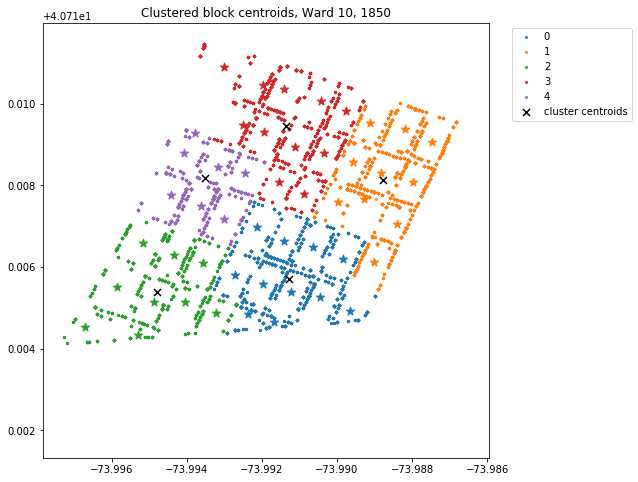

In [22]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols,
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [23]:
interpolate_sequences.cross_validate_model(k=10)
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

avg Training score: 0.8940362469742219
Test score: [0.5805915586573612, 0.6060500695410292, 0.6685121107266436, 0.6868279569892473, 0.5864903502501787, 0.5956614509246089, 0.6876949740034662, 0.6512856639661853, 0.6678520625889047, 0.6555901696088612]
avg Test score: 0.6386556367256486


## Train and test the model

In [24]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [25]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.8920272954996977
Test score: 0.5805915586573612


In [26]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [ ]:
# test.drop(columns=['level_0', 'index', 'sequence_id', 'num_between', 'sequence_order_enum', 'dist',
#        'sequence_len', 'fixed_seq', 'dwelling_seq_id', 'enum_dist_id',
#        'enum_dist_order', 'enum_dist', 'enum_sequence_len', 'similarity_label' ]).to_csv('../../classification_result_ward_10.csv', index=False)